# Visualizing Science - Citation Network Clustering

概要：数千本から数万分の論文のデータを取得し、引用情報をもとにネットワーククラスタリングを実施。各クラスタはopenAIのGPT4によりネーミングする。その後、各クラスタの関係性（引用/書誌結合）を視覚的に理解し、各クラスタの詳細情報を（最頻著者、最頻ジャーナル、平均出版年、キーワード）を表示する。

だいたい1000件〜10万件の論文を分析することを想定して可視化などのパラメータをチューニングしています。

実行時間は2000件で1-2分、4万件で15分ほど

今回のコードは以下の論文執筆時のコードを参考にしました。また、様々なオープンなライブラリを用いています。

Asatani, K., Takeda, H., Yamano, H., & Sakata, I. (2020). Scientific attention to sustainability and SDGs: Meta-analysis of academic papers. Energies, 13(4), 975. 
https://www.mdpi.com/1996-1073/13/4/975


## 初期設定


In [ ]:
import sys
import os

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path

In [1]:
%pip install pyalex
%pip install networkx
%pip install igraph
%pip install leidenalg
%pip install adjustText
%pip install openai==0.28

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

In [1]:
from pyalex import Works, Authors, Sources, Institutions, Concepts, Funders
import pyalex,openai,ast,pandas as pd, networkx as nx, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
import igraph as ig,leidenalg
import matplotlib.patheffects as patheffects
import random,time,itertools,tqdm,collections
from sklearn.feature_extraction.text import TfidfVectorizer
from networkx.drawing.nx_agraph import graphviz_layout
from adjustText import adjust_text

import util

flatten = lambda x: list(itertools.chain.from_iterable(x))

/Users/ti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
pyalex.config.email = "your@email.address"

In [3]:

cols = ["id","title","publication_year","referenced_works","cited_by_count","authorships", "locations",]
# def getAll(pyalexObj):
#     pager = pyalexObj.paginate(per_page=200,n_max=None)
#     arr = []
#     for page in tqdm.tqdm(pager):
#         arr += page
#     return arr
def get_tab20_color_hex(index):
    if index!=index:
        return None
    cmap = plt.get_cmap('tab20')
    actual_index = index % 20
    rgb_color = cmap(int(actual_index))[:3]  # Ignore the alpha value   
    hex_color = '#%02x%02x%02x' % (int(rgb_color[0]*255), int(rgb_color[1]*255), int(rgb_color[2]*255))
    return hex_color



# 論文の取得

1000件〜10万件の論文を分析することを想定して

- 選択肢1 特定のTopicから論文を抽出
    - Pros: OpenAlexのTopicがしっかり定義されているときはTopic内の構造が理解できる
    - Cons: フィールドにぬけもれがある、また新しい領域がフィールドとして定義されているとは限らない
    - How to use: Web版で https://openalex.org/topics/t10102 などのフィールドを見つける ⇒ t10102を指定して検索
    - 各論文は1つもしくは複数のtopicsが割り当てられており、1つのprimary_topicsが割り当てられている
    - primary_topics=t10102検索すると少ないが純度が高い集合、topics=t10102で検索すると関連する領域まで取れる
- 選択肢2 特定のJournalから論文を抽出
    - Pros: Journal内の論文をすべて取り出し網羅的に分野を俯瞰できる
    - Cons: 分析結果がJournal内に絞られる、総合誌だとぜんぜん違う分野が出てきて分野を深堀りするということにはならない
    - How to use: Web版で https://openalex.org/sources/s35412551 などのジャーナルを見つける ⇒ s35412551を指定して検索
- 選択肢３ 特定のキーワードから論文を抽出
    - Pros: 興味のある論文群を対象に直感的な分析ができる
    - Cons: キーワードの工夫が必要。キーワードによっては多く取りすぎたり絞りすぎたりする。例: transformerといれると自然言語処理と電気工学の論文が取れる
    - Cons: アブストラクトがデータベースにない論文はヒットしづらくバイアスがある集合になる
    - How to use: Web版で https://openalex.org/　でキーワードを検索してみる ⇒ そのキーワードを指定して検索

## 選択肢1 特定のTopicから論文を抽出 (選択肢1-3の何れかを実行)

In [3]:
# OpenAlexにおいて、Topicは以下の画像のような関係になっています。
# 上位階層から下位階層まで（階層名 分類数）
# Domain 4
# Filed 26
# Subfields 252
# Topic 4516
# 今回はt10102(Bibliometric Analysis and Research Evaluation)の10本以上の被引用数の論文を選択

### Edit here
"https://openalex.org/topics/t10102"
THRESHOLD = 18
pyalexObj = Works().filter(topics={"id":"t10102"}, cited_by_count=f">{THRESHOLD-1}",publication_year=f">{2010}").select(cols)

# pyalexObj = Works().filter(primary_topic={"id":"1804"}, cited_by_count=f">{THRESHOLD-1}").select(cols)
###

field_count = pyalexObj.count()
print(field_count)
works =  pd.DataFrame(util.getAll(pyalexObj)).drop_duplicates(subset=['id'])
print(f"取得した論文数/分野内の論文数：{len(works)}/{field_count} ({round(len(works)/field_count*100,2)}%)" )

2347
Fetching 2347 objects. it may takes 0.2 to 0.59 minutes


13it [00:22,  1.75s/it]

取得した論文数/分野内の論文数：2345/2347 (99.91%)


## 選択肢2 特定のJournalから論文を抽出 (選択肢1-3の何れかを実行)

In [139]:
# 今回はPhysical Review Eの2014年以降の論文を抽出
# イレギュラーケースですがPhysical Review Eは2015年を境に2つのidが割り振られています
# そのため、その２つのIDを | でつないてor検索します

### Edit here
source_id = "https://openalex.org/sources/s35412551"
source_id2 = "https://openalex.org/sources/s4210235286"
pyalexObj = Works().filter(locations={"source":{"id":source_id+"|"+source_id2}},publication_year=f">{2013}").select(cols)
### 

field_count = pyalexObj.count()
print(field_count)
works =  pd.DataFrame(util.getAll(pyalexObj)).drop_duplicates(subset=['id'])
print(f"取得した論文数/分野内の論文数：{len(works)}/{field_count} ({round(len(works)/field_count*100,2)}%)" )

21807


15it [00:31,  2.08s/it]

KeyboardInterrupt



## 選択肢３ 特定のキーワードから論文を抽出  (選択肢1-3の何れかを実行)

In [4]:
# 論文のタイトルアブストからキーワード検索します。

### Edit here

# deep learning関連の2021年以降の論文を抽出。クエリは改善の余地あり
# keyword = '"neural networks"|"deep learning"|"deep neural networks"|"neural language"|"LLM"|"large laungage model"|"transformer network"|"lstm network"'
# THRESHOLD = 10
# pyalexObj = Works().filter(title_and_abstract={"search":keyword}, publication_year=f">{2020}", cited_by_count=f">{THRESHOLD-1}").select(cols)

# LLM関連の2016年以降の論文を抽出。クエリは改善の余地あり
keyword = '"language models"|LLM|"chatGPT"|"GPT-4"|"GPT-3"|"LLAMA language"'
THRESHOLD = 0
pyalexObj = Works().filter(title_and_abstract={"search":keyword}, publication_year=f">{2020}", cited_by_count=f">{THRESHOLD-1}",has_references="true").select(cols)

### 


field_count = pyalexObj.count()
print(field_count)
works =  pd.DataFrame(util.getAll(pyalexObj)).drop_duplicates(subset=['id'])
print(f"取得した論文数/分野内の論文数：{len(works)}/{field_count} ({round(len(works)/field_count*100,2)}%)" )

34729


116it [04:08,  2.14s/it]


KeyboardInterrupt: 

# 引用ネットワークの作成　直接引用ネットワーク or 書誌結合ネットワーク

![network_rules](./supplementary/2_2edge_rules.png)

- 対象論文群間で引用数が十分に多い場合⇒直接引用ネットワーク
- そうでない場合⇒書誌結合ネットワーク
- 対象論文が少ない場合は、引用文献間の共引用ネットワークをみることで先行研究の分野を俯瞰できる（今回はスキップ）
- 例えば、2020年以降の論文だけを分析する場合は直接引用が疎になりがちなため、書誌結合で分析

In [6]:
# ネットワークの作成

### Edit here
NETWORK = 'coupling' #direct:直接引用ネットワーク, coupling:書誌結合ネットワーク、both:直接引用ネットワーク＋書誌結合ネットワーク
MIN_COUPLING = 3 #書誌結合ネットワークにおいてノード(論文)間にエッジを引くときに最低必要な共通する参考文献
EXCEPTION_THRESHOLD_HIGHLY_CITED_REFERENCE = 300 #書誌結合ネットワークにおいて、ここで指定した以上の対象文献からの被引用がある参考文献を除く
### 

edge_list = []

if NETWORK=='direct' or NETWORK=='both' :
    works_id = set(works.id)
    works["referenced_works_"] = works.referenced_works.apply(lambda x:  set(x) & works_id  )
    edge_list += flatten([[[v.id, x] for x in v.referenced_works_ if x != v.id ] for k,v in works.iterrows()])
    print(len(edge_list))
    
if NETWORK == 'coupling' or NETWORK=='both' :
    edges = []
    for k,v in works[["id","referenced_works"]].explode(column="referenced_works").groupby("referenced_works"):
        if len(v)>=2 and len(v)<=EXCEPTION_THRESHOLD_HIGHLY_CITED_REFERENCE:
            edges.append(list(itertools.combinations(v.id,2)))
    edges = flatten(edges)
    tuple_counts = collections.Counter(edges)
    edge_list += [tpl for tpl, count in tuple_counts.items() if count >= MIN_COUPLING]
    print(len(edge_list))
    
G = nx.from_edgelist(edge_list)
print("ネットワーク　ノード数　エッジ数：",len(G.nodes()),len(G.edges()))
G = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
print("最大連結ネットワーク　ノード数　エッジ数：",len(G.nodes()),len(G.edges()))

41606
ネットワーク　ノード数　エッジ数： 2050 41606
最大連結ネットワーク　ノード数　エッジ数： 2044 41603


# 引用ネットワークのクラスタリング

ネットワークにはノードが密集しているようなコミュニティ構造が見られることが多々あります。このような構造を有効に検出するための手法としてクラスタリングが挙げられます。  

![example_cluster](./supplementary/example_cluster.png)

例えば、このネットワークでは青とオレンジにノードをクラスタリングするのが直感的に適切です。
クラスタ内のエッジの数がクラスタ間のエッジの数の数に比べて多いとよい分割といえます。

その分割のよさはモジュラリティという指標で測ることができます。
モジュラリティを最大化するようなコミュニティ分割を見つける手法が一般的です。  

$$
Q = \frac{1}{2m} \sum_{i,j} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \delta(c_i, c_j)
$$

$Q$: モジュラリティ \\
$A_{ij}$: ノード$i$とノード$j$の接続関係を表す非負の値（0か1の二値で表現される） \\
$k_i$: ノード$i$の次数 \\
$c_i$: ノード $i$ が属するコミュニティ \\
$\delta(c_i, c_j)$: コミュニティ $c_i$ と $c_j$ が同じかどうかを示すδ関数（0か1の二値で表現される） \\
$m$: エッジの総数 \\

モジュラリティを最適化するアルゴリズムとして長らくLouvain法と呼ばれる手法を用いられてきましたが、近年ではその改良版であるleiden法を用いることが増えてきました。  




In [7]:
# ネットワークのクラスタリングの実行とデータの格納
def do_leidenpartitioning(G):  
    g = ig.Graph.TupleList(G.edges(), directed=False)
    part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
    partition = pd.DataFrame({"node":[g['name'] for g in g.vs],"partition":part.membership}).set_index('node').partition
    return partition.to_dict()
partiton = do_leidenpartitioning(G)
works['partition'] = works.id.map(partiton)
print("top 10 largest partitions\n",works['partition'].value_counts().sort_values(ascending=False)[:10])

top 10 largest partitions
 partition
0.0    431
1.0    394
2.0    273
3.0    245
4.0    220
5.0    178
6.0    157
7.0    109
8.0     29
9.0      8
Name: count, dtype: int64


/var/folders/fn/7ymcb_ld5c78xqjx1s653sbm0000gn/T/ipykernel_63750/1600949331.py:9: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  print("top 10 largest partitions\n",works['partition'].value_counts().sort_values(ascending=False)[:10])


# クラスタのネーミング

ここでは分割された各クラスタの基本情報を取得します。

まずクラスタにある論文の集合をネーミングします。
- (step1) TF-IDFで各クラスタの論文内に特徴的によく出てくる単語をカウントします。
    - TFIDF(単語W,論文P) = TF(論文P中の単語Wの数) * IDF( 1/ その単語Pが出てくる論文数)
    - TFIDF_marged(クラスタC, 単語P) = Σ_(クラスタC中の論文P)　TFIDF(単語W,論文P)
- (step2) 各クラスタのTFIDFトップ30単語をもとに、各クラスタのネーミングをGPT4につけてもらいます
    - 質問文: The following sets of keywords show the label number and most frequent and characteristic terms in a given discipline. Please name them...  1. language, model, text... 2. transformer, power...
    - APIでGPT4から回答を取得して各クラスタのネームとする


In [8]:
# 各クラスタのTF-IDF値の算出

works_ = works.dropna(subset=['title'])
works_.index=range(len(works_))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(works_.title)
feature_names = vectorizer.get_feature_names_out()

top_tfidf = {}
for k,v in works_.groupby("partition"):
    aggregate_scores = np.asarray(tfidf_matrix[v.index].sum(axis=0)).ravel()
    term_scores = {feature_names[i]: aggregate_scores[i] for i in range(len(feature_names))}
    top_terms = list(pd.Series(term_scores).sort_values(ascending=False)[:100].index)
    top_tfidf[k] = top_terms

partition_info = pd.Series(top_tfidf).to_frame()
partition_info.columns = ['top_tfidf']
partition_info['top_tfidf'].head()

0.0    [collaboration, research, scientific, science,...
1.0    [impact, citation, research, index, bibliometr...
2.0    [science, systematic, research, reviews, meta,...
3.0    [peer, review, gender, research, productivity,...
4.0    [analysis, bibliometric, citation, research, s...
Name: top_tfidf, dtype: object

In [9]:
#　各クラスタのTF-IDFをもとにGPT4に質問し、各クラスタをネーミング optional
# 以下のコードはOpenAIのAPIを使用しています。APIの利用にはAPIキーが必要です。
# APIキーはOpenAIのサイトから取得してください。 https://platform.openai.com/docs/quickstart

partition_info['partition_name_GPT4'] = partition_info['top_tfidf'].apply(lambda x: ", ".join(x[:3]))

openai.api_key = "proj_*****"

counter = 0
for i in range(0,len(partition_info),30):
    try:
        counter += 1
        gpt_prompt =  """The following sets of keywords show the label number and most frequent and characteristic terms in a given discipline. Please name them appropriately for the discipline so that they encompass all words. The discipline name must be shorter than 5 words each.
        """
        for k,v in partition_info.iloc[i:i+30].top_tfidf.items():
            gpt_prompt += "{}: {} \n".format(k,", ".join(v[:50]).replace("_"," "))

    
        messages=[
            {"role": "system", "content": "Assistant is a large language model trained by OpenAI."},
            {"role": "user", "content": gpt_prompt}
        ]
        
        response = openai.ChatCompletion.create(
          model="gpt-4",
          messages=messages,
          max_tokens=2000
        )

        for s in response["choices"][0]["message"]["content"].split("\n"):
            cl = ast.literal_eval(s.split(":")[0])
            partition_info.loc[cl,'partition_name_GPT4'] = s.split(":")[1].strip()
        # print(response["choices"][0]["message"]["content"].split("\n"))

    except:
        if counter>10:
            break
        i = i - 1
partition_info['partition_name_GPT4'].head()

0.0    collaboration, research, scientific
1.0             impact, citation, research
2.0          science, systematic, research
3.0                   peer, review, gender
4.0       analysis, bibliometric, citation
Name: partition_name_GPT4, dtype: object

# クラスタの基本情報の取得

ここではクラスタの論文数、平均出版年、トップ著者、トップインパクト論文などの基本情報を取得します

In [10]:
def get_journal_name(x):
    try:
        return x[0]['source']['display_name']
    except:
        return None

works['journal'] = works.locations.apply(get_journal_name)
partition_info['year_mean'] = works.groupby('partition').publication_year.mean()
partition_info['num_paper'] = works.groupby('partition').publication_year.count()
partition_info['top_3_journals'] = works.groupby('partition')['journal'].apply(lambda x: x.value_counts().nlargest(3).index.tolist())
works['authors'] =works.authorships.apply(lambda x: [y['raw_author_name'] for y in x]).apply(set)
partition_info['top_authors'] = works[['partition',"authors"]].explode(column="authors").groupby('partition')['authors'].apply(lambda x: x.value_counts().nlargest(3).index.tolist())
works['institutions'] = works.authorships.apply(lambda x: [ y['raw_affiliation_strings'][0] for y in x if ( y['raw_affiliation_strings'] not in ['View further author information','']  and len(y['raw_affiliation_strings'])>0)]).apply(set)
partition_info['top_institutions'] = works[['partition',"institutions"]].explode(column="institutions").groupby('partition')['institutions'].apply(lambda x: x.value_counts().nlargest(3).index.tolist())

top_papers_of_partition = works.groupby(['partition']).apply(lambda x: x.nlargest(3, 'cited_by_count')[['title','publication_year','journal','cited_by_count']])


# ネットワークの描画と結果の出力

In [11]:
#　ネットワークのレイアウトの作成
# pos = nx.spring_layout(G)は標準的だが遅いので、igraphのlayout_fruchterman_reingoldを用いる。

### Edit here
NITER=20000
###

h = ig.Graph.from_networkx(G)
layout = list(h.layout_fruchterman_reingold(niter=NITER))
pos = {v['_nx_name']:np.array(l) for v,l in zip(h.vs(),layout)}

/Users/ti/Library/Python/3.9/lib/python/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


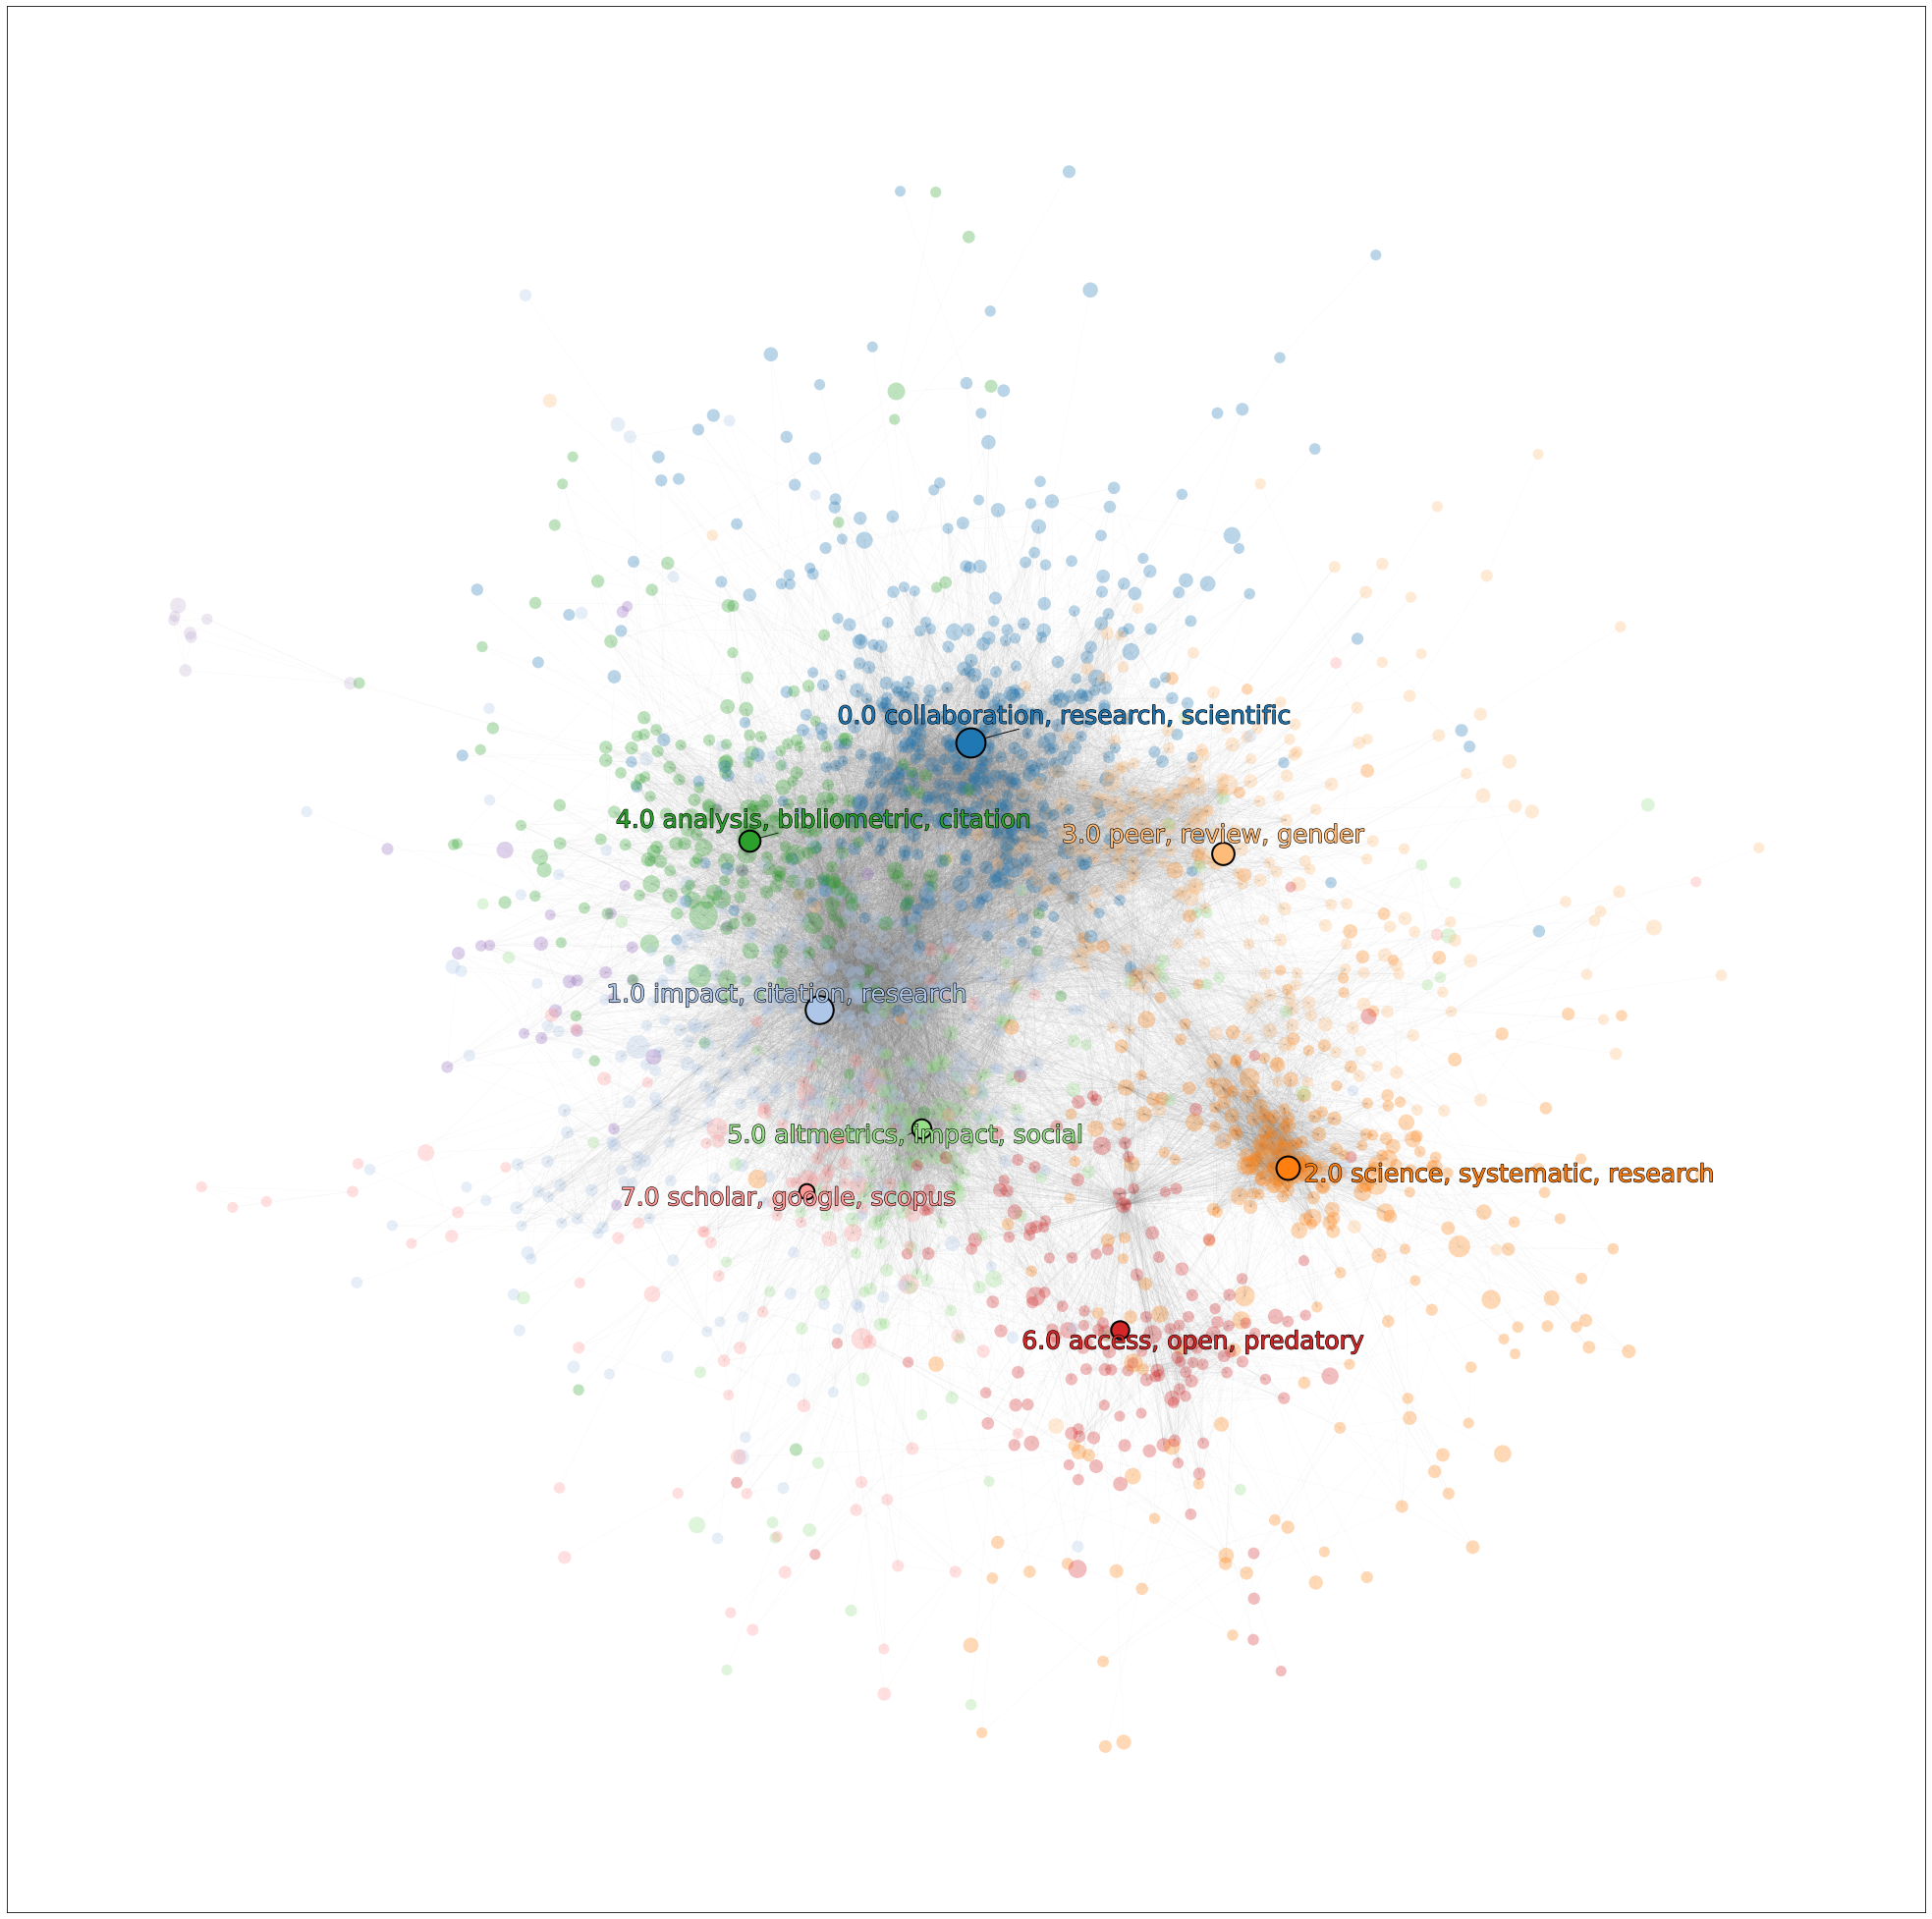

In [12]:
# グラフの描画に必要な情報の整理
plt.rcParams['figure.dpi'] = 72

### Please edit some parameter of following codes
works['posx'] = works.id.map(pos).dropna().apply(lambda x: x[0])
works['posy'] = works.id.map(pos).dropna().apply(lambda x: x[1])
works['node_color'] = works.partition.apply(get_tab20_color_hex)
works.index = works.id
cited_by_count = works.set_index('id').cited_by_count
node_colors=[works.node_color.loc[n] for n in G.nodes()] 
node_sizes=[ np.sqrt(works.cited_by_count.loc[n] + 1) for n in G.nodes()] 
node_sizes = [35 +(s * 1000) / max(node_sizes) for s in node_sizes ]

# グラフの描画
fig, ax = plt.subplots(figsize=(35, 35))
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=node_sizes,alpha=0.3,linewidths=0,
                       cmap='tab20',ax=ax,)
nx.draw_networkx_edges(G, pos=pos ,edge_color="gray", width=0.15, alpha=0.2,ax=ax)

texts = []
for k,v in works.groupby('partition'):
    if len(v)>=50:
        posx = v.posx.median()
        posy = v.posy.median()
        ax.scatter([posx],[posy],s=25+len(v)*2,color=get_tab20_color_hex(k),edgecolors='black',linewidth=2,zorder=2)
        texts.append(ax.annotate("{} {}".format(k, partition_info.loc[k].partition_name_GPT4)
                                 , xy=(posx,posy), fontsize=25, color=get_tab20_color_hex(k),zorder=2,
                                 path_effects=[patheffects.withStroke(linewidth=1.2, foreground='black', capstyle="round")]))

adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'))

plt.show()

<Figure size 2160x2160 with 0 Axes>

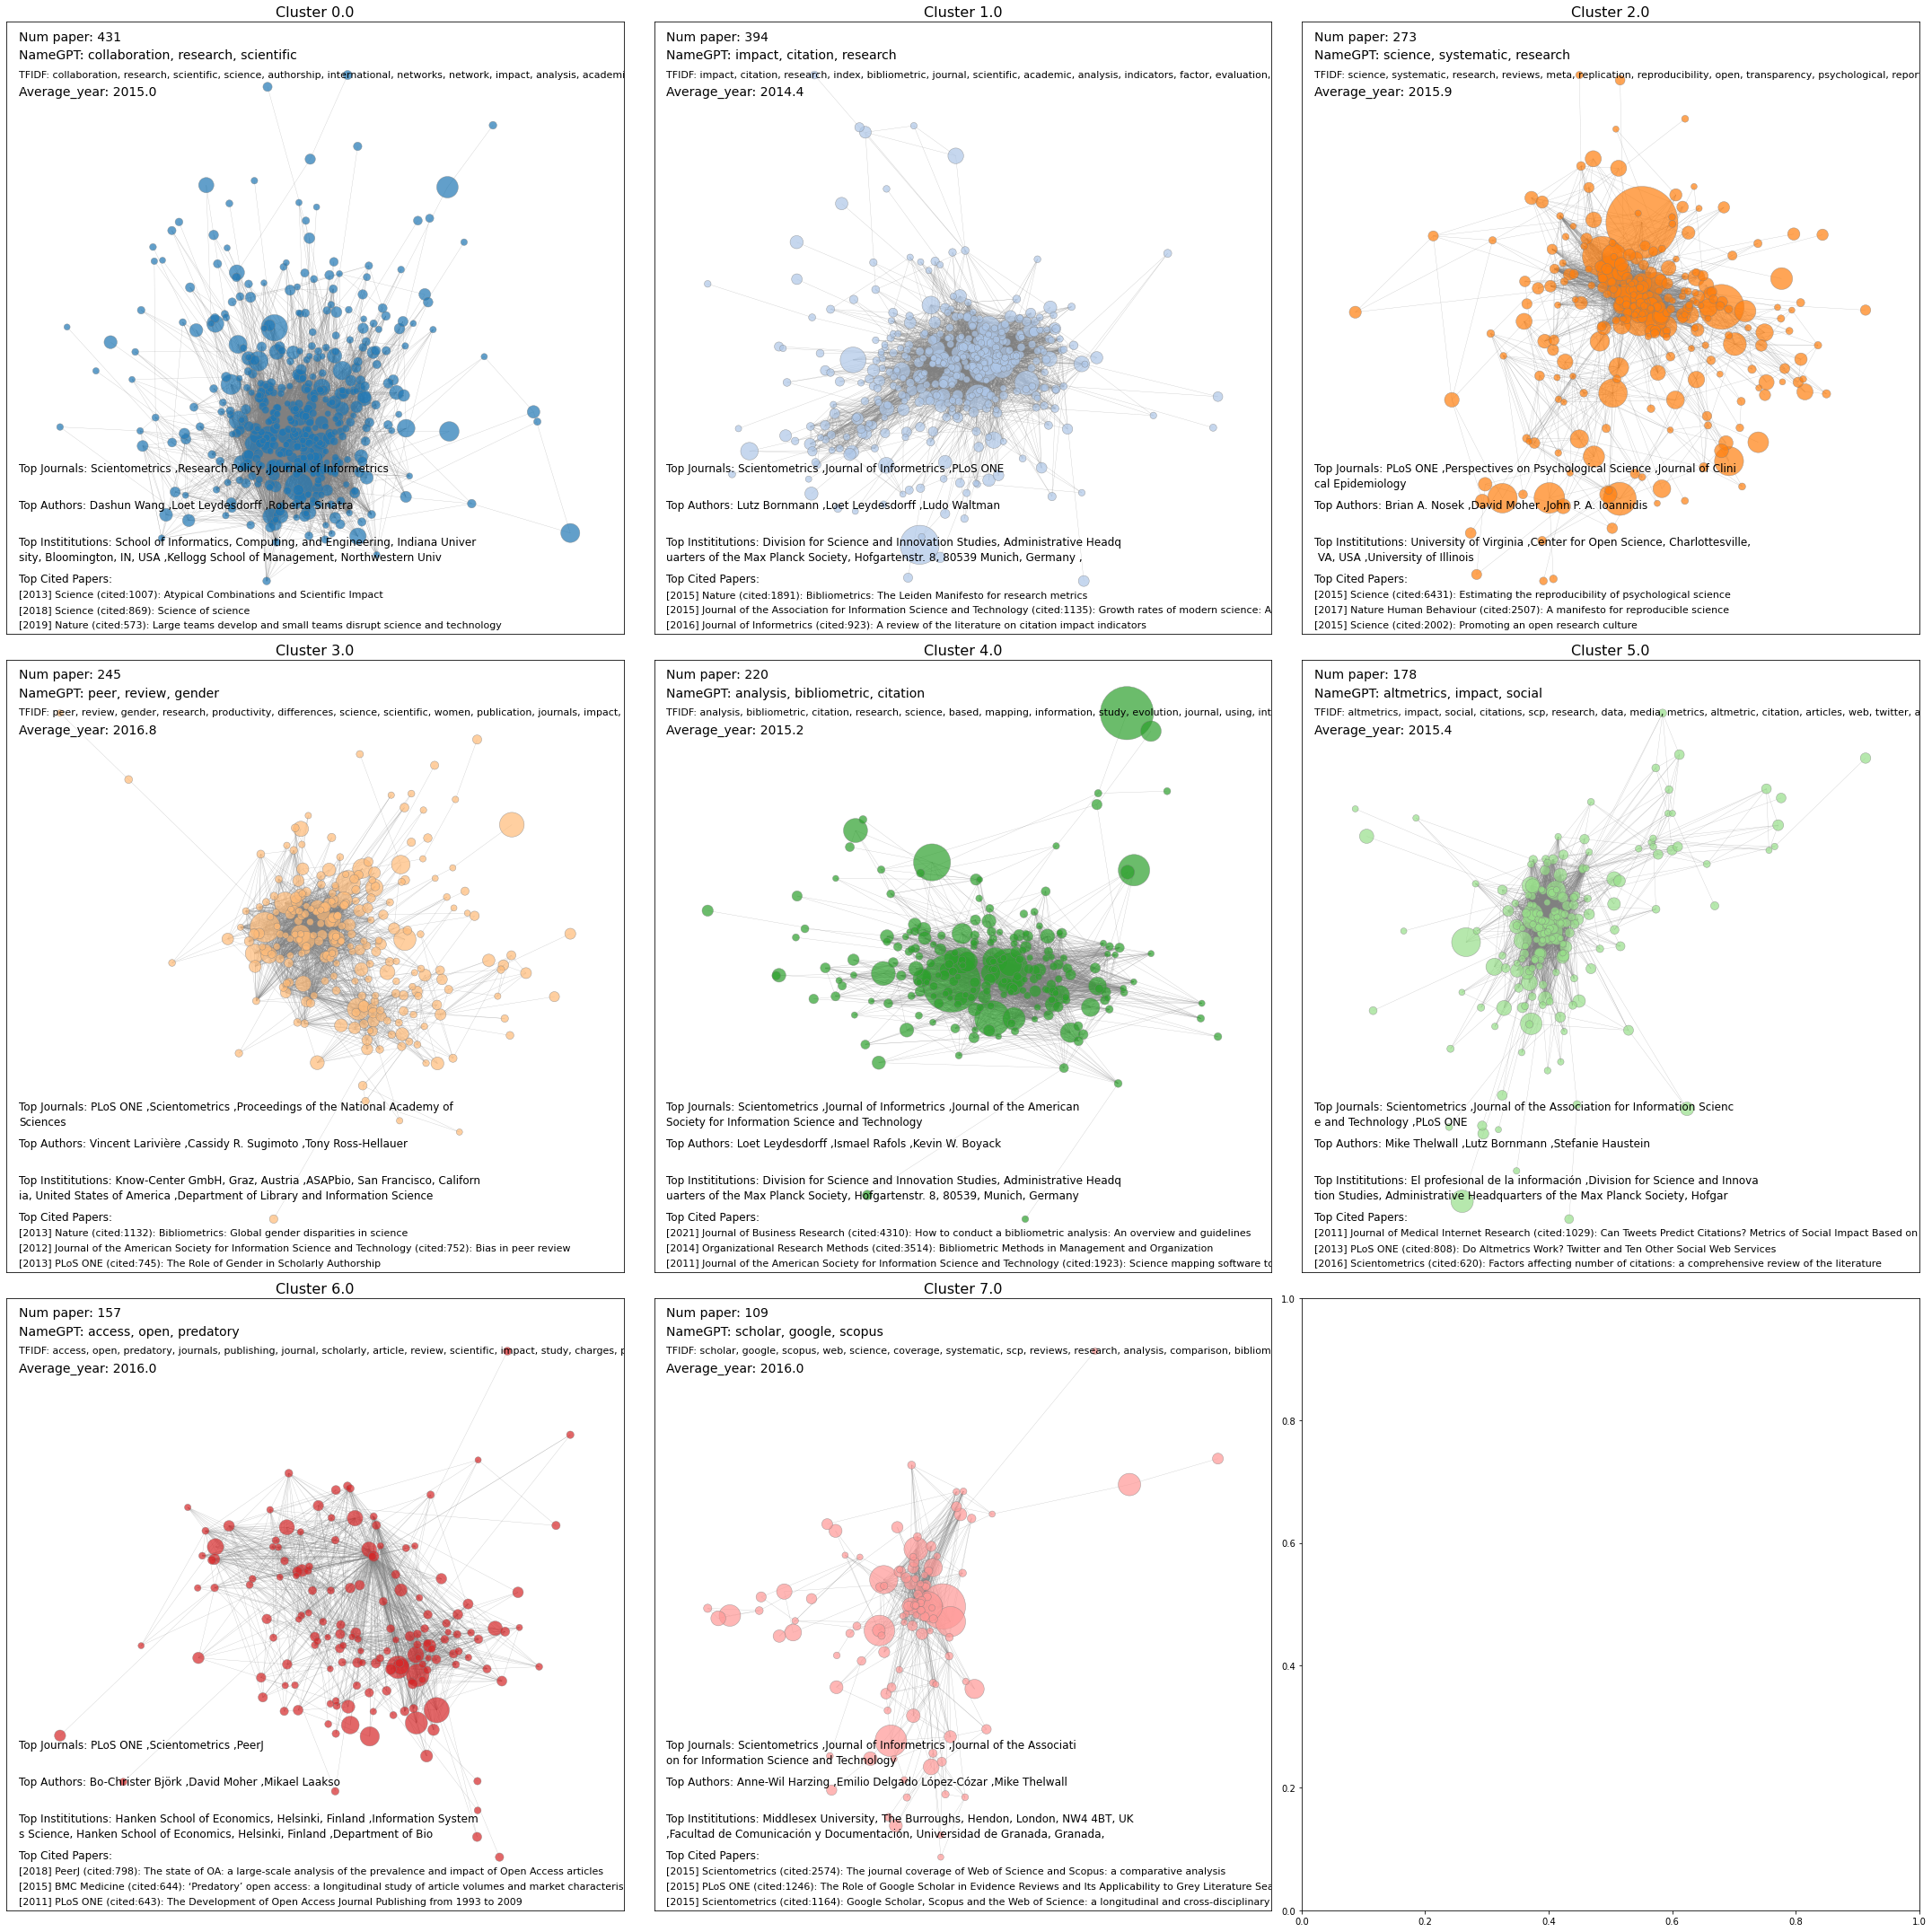

In [13]:

# Draw the graph with nodes colored according to their cluster membership

# Create a dictionary to store the nodes of each cluster
num_vertical = len(partition_info.query('num_paper>=50'))//3+1
# Draw the subgraphs for each cluster
plt.figure(figsize=(30,num_vertical* 10))


fig, axs = plt.subplots(num_vertical,3, figsize=(30,num_vertical* 10))

for cluster, v in partition_info.query('num_paper>=50').iterrows():
    ax = axs[int(cluster/3)][int(cluster%3)]

    nodes = works.query('partition==@cluster').id   
    node_colors=[works.node_color.loc[n] for n in nodes] 
    node_sizes=[works.cited_by_count.loc[n] for n in nodes] 

    nx.draw_networkx_edges(G.subgraph(nodes), pos=pos, edge_color='gray',width=0.3,alpha=0.5,ax=ax)
    nx.draw_networkx_nodes(G.subgraph(nodes), pos=pos, node_color=node_colors, node_size=node_sizes, edgecolors='gray',linewidths=0.5,alpha=0.7,ax=ax)
    ax.set_title(f"Cluster {str(cluster)}", fontsize=16)


    d = -0.06
    ax.text(0.02, 1.03+d, "Num paper: " + str(v.num_paper), ha='left',fontsize=14, clip_on=True, transform=ax.transAxes,)
    ax.text(0.02, 1+d, "NameGPT: " + v.partition_name_GPT4, ha='left',fontsize=14, clip_on=True, transform=ax.transAxes,)
    ax.text(0.02, 0.97+d, "TFIDF: " + ", ".join(v.top_tfidf)[:150], ha='left',fontsize=11, clip_on=True, transform=ax.transAxes,)
    ax.text(0.02, 0.94+d, "Average_year: " + str(v.year_mean)[:6], ha='left',fontsize=14, clip_on=True, transform=ax.transAxes,)
    
    d = 0.24
    tmp = " ,".join(v.top_3_journals)
    ax.text(0.02, 0.025+d, "Top Journals: " +  tmp[:65], ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)
    ax.text(0.02, 0.0+d, tmp[65:140], ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)

    d = 0.18
    tmp = " ,".join(v.top_authors)
    ax.text(0.02, 0.025+d, "Top Authors: " +  tmp[:65], ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)
    ax.text(0.02, 0.0+d, tmp[65:140], ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)

    d = 0.12
    tmp = " ,".join(v.top_institutions)
    ax.text(0.02, 0.025+d, "Top Instititutions: " +  tmp[:65], ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)
    ax.text(0.02, 0.0+d, tmp[65:140], ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)

    d = 0.06
    ax.text(0.02, 0.025+d, "Top Cited Papers: ", ha='left',fontsize=12, clip_on=True, transform=ax.transAxes)
    tmp = top_papers_of_partition.loc[cluster].iloc[0]
    ax.text(0.02, -0.00+d, "[{}] {} (cited:{}): {}".format(tmp.publication_year,tmp.journal,tmp.cited_by_count,tmp.title)[:200], ha='left',fontsize=11, clip_on=True, transform=ax.transAxes)
    tmp = top_papers_of_partition.loc[cluster].iloc[1]
    ax.text(0.02, -0.025+d, "[{}] {} (cited:{}): {}".format(tmp.publication_year,tmp.journal,tmp.cited_by_count,tmp.title)[:200], ha='left',fontsize=11, clip_on=True, transform=ax.transAxes)
    tmp = top_papers_of_partition.loc[cluster].iloc[2]
    ax.text(0.02, -0.05+d, "[{}] {} (cited:{}): {}".format(tmp.publication_year,tmp.journal,tmp.cited_by_count,tmp.title)[:200], ha='left',fontsize=11, clip_on=True, transform=ax.transAxes)


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.tight_layout()
plt.show()